In this file, we are conducting experiment to explore the 3 fators that influence GP performance and speed. They are 1. kernel choice 2. interpolation method 3. Whether to include LOVE. We number our experiment A i.j.k in the following way:

first dim i (kernel choice) - 1: RBF 2: Periodic 3. RBF + Period

second dim j (interpolation method) - 1: without SKI 2:with SKI 3: with SGPR

third dim k (Whether to Include LOVE?) - 1:No LOVE 2:with LOVE

There are 3*3*2 = 18 Models in this set of expeiment, they are

model_name_list = [[['Model A.1.1.1: RBF + No Sparsing + No LOVE', 'Model A.1.1.2: RBF + No Sparsing + LOVE'], ['Model A.1.2.1: RBF + SKI + No LOVE', 'Model A.1.2.2: RBF + SKI + LOVE'], ['Model A.1.3.1: RBF + SGPR + No Love', 'Model A.1.3.2: RBF + SGPR + LOVE']],\
         [['Model A.2.1.1: Periodic + No Sparsing + No LOVE', 'Model 2.1.2: Periodic + No Sparsing + LOVE'], ['Model A.2.2.1: Periodic + SKI + No LOVE', 'Model A.2.2.2: Periodic + SKI + LOVE' ], ['Model A.2.3.1: Periodic + SGPR + No Love', 'Model A.2.3.2: Periodic + SGPR + LOVE' ]], \
         [['Model A.3.1.1: RBF + Periodic + No Sparsing + No LOVE', 'Model A.3.1.2: RBF + Periodic + No Sparsing + LOVE'], ['Model A.3.2.1: RBF + Periodic + SKI + No LOVE', 'Model A.3.2.2: RBF + Periodic + SKI + LOVE'], ['Model A.3.3.1: RBF + Periodic + SGPR + No Love', 'Model A.3.3.2: RBF + Periodic + SGPR + LOVE']]]

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
import random
from sklearn.preprocessing import StandardScaler

# Make plots inline
%matplotlib inline

In [2]:
random.seed(666)

# 1 Read Data

In [3]:
#read the data and create data frame
df = pd.read_csv('heart_rate_data.csv')
df['time'] = np.linspace(0, 900, len(df))
df.columns = ['Y','time']
print(df.shape)
df.head(3)

(1799, 2)


Y      time
0  84.2697  0.000000
1  84.0619  0.500556
2  85.6542  1.001112

In [4]:
#normalize Y
Y = df['Y'].to_numpy().reshape(-1, 1)
transformer = StandardScaler().fit(Y)
df['Y'] = transformer.transform(Y)
print(df.shape)
df.head(3)

(1799, 2)


Y      time
0 -1.518649  0.000000
1 -1.556528  0.500556
2 -1.266271  1.001112

In [5]:
#split the training and testing set, convert them to tensor format
from sklearn.model_selection import train_test_split
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(df['time'][:600], df['Y'][:600], test_size = 0.3, random_state= 66)
X_train_, Y_train_, X_test_, Y_test_ = X_train_.sort_index(), Y_train_.sort_index(), X_test_.sort_index(), Y_test_.sort_index()
X_train_, Y_train_, X_test_, Y_test_  = np.array(X_train_), np.array(Y_train_), np.array(X_test_), np.array(Y_test_)
X_train, Y_train, X_test, Y_test = torch.tensor(X_train_), torch.tensor(Y_train_), torch.tensor(X_test_), torch.tensor(Y_test_)
X_all_linspace = np.arange(0, float(df['time'][600]), 0.5)
X_all_linspace = torch.tensor(X_all_linspace)

# 2 Implement Model with GpyTorch

## Settings and Functions for Experiment

In [6]:
#we have 3 * 3 * 2 = 18 experiment in our first set
model_name_list = [[['Model A.1.1.1: RBF + No Sparsing + No LOVE', 'Model A.1.1.2: RBF + No Sparsing + LOVE'], ['Model A.1.2.1: RBF + SKI + No LOVE', 'Model A.1.2.2: RBF + SKI + LOVE'], ['Model A.1.3.1: RBF + SGPR + No LOVE', 'Model A.1.3.2: RBF + SGPR + LOVE']],\
         [['Model A.2.1.1: Periodic + No Sparsing + No LOVE', 'Model 2.1.2: Periodic + No Sparsing + LOVE'], ['Model A.2.2.1: Periodic + SKI + No LOVE', 'Model A.2.2.2: Periodic + SKI + LOVE' ], ['Model A.2.3.1: Periodic + SGPR + No LOVE', 'Model A.2.3.2: Periodic + SGPR + LOVE' ]], \
         [['Model A.3.1.1: RBF + Periodic + No Sparsing + No LOVE', 'Model A.3.1.2: RBF + Periodic + No Sparsing + LOVE'], ['Model A.3.2.1: RBF + Periodic + SKI + No LOVE', 'Model A.3.2.2: RBF + Periodic + SKI + LOVE'], ['Model A.3.3.1: RBF + Periodic + SGPR + No LOVE', 'Model A.3.3.2: RBF + Periodic + SGPR + LOVE']]]

In [7]:
model_name_list 

[[['Model A.1.1.1: RBF + No Sparsing + No LOVE',
   'Model A.1.1.2: RBF + No Sparsing + LOVE'],
  ['Model A.1.2.1: RBF + SKI + No LOVE', 'Model A.1.2.2: RBF + SKI + LOVE'],
  ['Model A.1.3.1: RBF + SGPR + No LOVE', 'Model A.1.3.2: RBF + SGPR + LOVE']],
 [['Model A.2.1.1: Periodic + No Sparsing + No LOVE',
   'Model 2.1.2: Periodic + No Sparsing + LOVE'],
  ['Model A.2.2.1: Periodic + SKI + No LOVE',
   'Model A.2.2.2: Periodic + SKI + LOVE'],
  ['Model A.2.3.1: Periodic + SGPR + No LOVE',
   'Model A.2.3.2: Periodic + SGPR + LOVE']],
 [['Model A.3.1.1: RBF + Periodic + No Sparsing + No LOVE',
   'Model A.3.1.2: RBF + Periodic + No Sparsing + LOVE'],
  ['Model A.3.2.1: RBF + Periodic + SKI + No LOVE',
   'Model A.3.2.2: RBF + Periodic + SKI + LOVE'],
  ['Model A.3.3.1: RBF + Periodic + SGPR + No LOVE',
   'Model A.3.3.2: RBF + Periodic + SGPR + LOVE']]]

In [8]:
kernel_list = [gpytorch.kernels.RBFKernel(), gpytorch.kernels.PeriodicKernel(), gpytorch.kernels.RBFKernel() + gpytorch.kernels.PeriodicKernel()]

In [9]:
def plot_loss_in_training_process(experiment_index, train_losses_mll, test_losses_mse, test_losses_msll):
    #plot loss log
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    fig_name = model_name_list[experiment_index[0]][experiment_index[1]][experiment_index[2]] + ' Loss w.r.t Training Epoch'
    fig.suptitle(fig_name)

    axs[0].plot(train_losses_mll, label = 'Training Loss MLL')
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('Loss (MLL)')
    axs[0].set_title('Training Error')
    axs[0].legend()

    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('Loss (MSE)')
    axs[1].plot(test_losses_mse, label = 'Testing Loss MSE', c = 'orange')
    axs[1].set_title('testing error')
    axs[1].legend()

    axs[2].set_xlabel('Iterations')
    axs[2].set_ylabel('Loss (MSLL)')
    axs[2].plot(test_losses_msll, label = 'Testing Loss MSLL', c = 'purple')
    axs[2].set_title('Testing Error')
    axs[2].legend()

    save_to = 'Experiment_A_Figure/' + fig_name + '.png'
    plt.savefig(save_to)

In [10]:
def plot_predicting_result_LOVE(model, likelihood, experiment_index):
    model.eval()
    likelihood.eval()
    
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        all_prediction = likelihood(model(X_all_linspace))
        all_mean = all_prediction.mean
        all_lower, all_upper = all_prediction.confidence_region()
        
    plt.figure(figsize=(12,8))
    plt.plot(X_train, Y_train, 'y.', markersize=10, label='Training Data') #plot training data
    plt.plot(X_test, Y_test, 'bx', markersize=6, label='Testing Data') #plot testing data
    plt.plot(X_all_linspace, all_mean, 'g-', label='Posterier Mean') # plot training prediction
    plt.fill_between(X_all_linspace, all_lower, all_upper, alpha=0.5, label = 'Posterior CI') #add CI
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    fig_name = model_name_list[experiment_index[0]][experiment_index[1]][experiment_index[2]] +  ' Inference Result'
    plt.title(fig_name)
    plt.legend(loc='upper left')
    save_to = 'Experiment_A_Figure/' + fig_name + '.png'
    plt.savefig(save_to)
    plt.show()
    plt.close()

In [11]:
def plot_predicting_result_NO_LOVE(model, likelihood, experiment_index):
    model.eval()
    likelihood.eval()
    
    with torch.no_grad():
        all_prediction = likelihood(model(X_all_linspace))
        all_mean = all_prediction.mean
        all_lower, all_upper = all_prediction.confidence_region()
    
    plt.figure(figsize=(12,8))
    plt.plot(X_train, Y_train, 'y.', markersize=10, label='Training Data') #plot training data
    plt.plot(X_test, Y_test, 'bx', markersize=6, label='Testing Data') #plot testing data
    plt.plot(X_all_linspace, all_mean, 'g-', label='Posterier Mean') # plot training prediction
    plt.fill_between(X_all_linspace, all_lower, all_upper, alpha=0.5, label = 'Posterior CI') #add CI
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    fig_name = model_name_list[experiment_index[0]][experiment_index[1]][experiment_index[2]] +  ' Inference Result'
    plt.title(fig_name)
    plt.legend(loc='upper left')
    save_to = 'Experiment_A_Figure/' + fig_name + '.png'
    plt.savefig(save_to)
    plt.show()
    plt.close()

In [12]:
def inference_time(model, likelihood, current_experiment_index):
    N = 1000
    model.eval()
    likelihood.eval()
    if current_experiment_index[2] == 0:# without love
        with torch.no_grad():
            start_time = time.time()
            test_inference = torch.linspace(0, float(df['time'][600]), N).double()                  
            test_inference_pred = likelihood(model(test_inference))
            end_time = time.time()
    else: 
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            start_time = time.time()
            test_inference = torch.linspace(0, float(df['time'][600]), N).double()                  
            test_inference_pred = likelihood(model(test_inference))
            end_time = time.time()
    return end_time - start_time

In [13]:
def training(model, likelihood, optimizer, mll, training_iterations = 300):
    start_time = time.time()
    train_losses_mll = []
    test_losses_mse = []
    test_losses_msll = []
    time_list = []

    for epoch in range(training_iterations):
        #get train loss for this iter
        model.train()
        likelihood.train()
        optimizer.zero_grad()
        train_predition = model(X_train)
        train_loss = -mll(train_predition, Y_train)        
        train_losses_mll.append(train_loss)
        time_list.append(time.time() - start_time)
        train_loss.backward()
        optimizer.step()

        #get test loss for this iter
        model.eval()
        with torch.no_grad():
            trained_pred_dist = likelihood(model(X_test))
            predictive_mean = trained_pred_dist.mean
            lower, upper = trained_pred_dist.confidence_region()
            #here we use mse instead of marginal log likelihood because 
            #ow error occur: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06
            test_msll = gpytorch.metrics.mean_standardized_log_loss(trained_pred_dist, Y_test)
            test_mse = np.mean(np.square(np.array(predictive_mean - Y_test)))
            test_losses_mse.append(test_mse)
            test_losses_msll.append(test_msll)
    
    end_time = time.time()
    train_losses_mll = [float(i) for i in train_losses_mll]
    test_losses_mse = [float(i) for i in test_losses_mse]
    test_losses_msll = [float(i) for i in test_losses_msll]

    print('tesing MSE after', training_iterations, 'epochs:', test_losses_mse[-1])
    print('tesing MSLL after', training_iterations, 'epochs:', test_losses_msll[-1])
    print('training duration for', training_iterations, 'epochs:', end_time - start_time)

    return time_list, train_losses_mll, test_losses_mse, test_losses_msll, end_time - start_time
    

In [14]:
def GP_experiment(experiment_index):
    current_experiment_index = experiment_index
    #define the model
    class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, experiment_index):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            
            grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0) # SKI requires a grid size hyperparameter.
            #we are going to warpping below kernel inside the interpolation kernel
            self.base_kernel = gpytorch.kernels.RBFKernel()

            #Exp-Sine-Squared kernel (aka periodic kernel)

            self.mean_module = gpytorch.means.ConstantMean()
            
            if experiment_index[1] == 0: #without SKI
                self.covar_module = gpytorch.kernels.ScaleKernel(kernel_list[experiment_index[0]])
            elif experiment_index[1] == 1:  #with SKI
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.GridInterpolationKernel(kernel_list[experiment_index[0]], grid_size=grid_size, num_dims=1))
            else: #SGPR
                m = 100
                test_inducing = torch.linspace(0, float(df['time'][600]), m).double()                      
                self.covar_module = gpytorch.kernels.InducingPointKernel(gpytorch.kernels.ScaleKernel(kernel_list[experiment_index[0]]), inducing_points=test_inducing, likelihood = likelihood)

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    #training
    likelihood = FixedNoiseGaussianLikelihood(torch.ones(len(X_train))* 0.01, learn_additional_noise=True)
    model = GPRegressionModel(X_train, Y_train, likelihood, current_experiment_index)
    
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    
    return model, likelihood

In [15]:
#These lists are for comparing training speed and performance for different models later
time_list_list = [[[None, None], [None, None], [None, None]],[[None, None], [None, None], [None, None]],[[None, None], [None, None], [None, None]]]
train_losses_mll_list = [[[None, None], [None, None], [None, None]],[[None, None], [None, None], [None, None]],[[None, None], [None, None], [None, None]]]
test_losses_mse_list = [[[None, None], [None, None], [None, None]],[[None, None], [None, None], [None, None]],[[None, None], [None, None], [None, None]]]
test_losses_msll_list = [[[None, None], [None, None], [None, None]],[[None, None], [None, None], [None, None]],[[None, None], [None, None], [None, None]]]
inference_duration_list = [[[None, None], [None, None], [None, None]],[[None, None], [None, None], [None, None]],[[None, None], [None, None], [None, None]]]

In [16]:
#function to add training log of current model to our record list above
def record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index):
    time_list_list[current_experiment_index[0]][current_experiment_index[1]][current_experiment_index[2]] = time_list
    train_losses_mll_list[current_experiment_index[0]][current_experiment_index[1]][current_experiment_index[2]] = train_losses_mll
    test_losses_mse_list[current_experiment_index[0]][current_experiment_index[1]][current_experiment_index[2]] = test_losses_mse
    test_losses_msll_list[current_experiment_index[0]][current_experiment_index[1]][current_experiment_index[2]] = test_losses_msll

## Model 1.1.1: RBF

tesing MSE after 300 epochs: 0.04452122125347812
tesing MSLL after 300 epochs: -0.42506945086423714
training duration for 300 epochs: 8.723474979400635


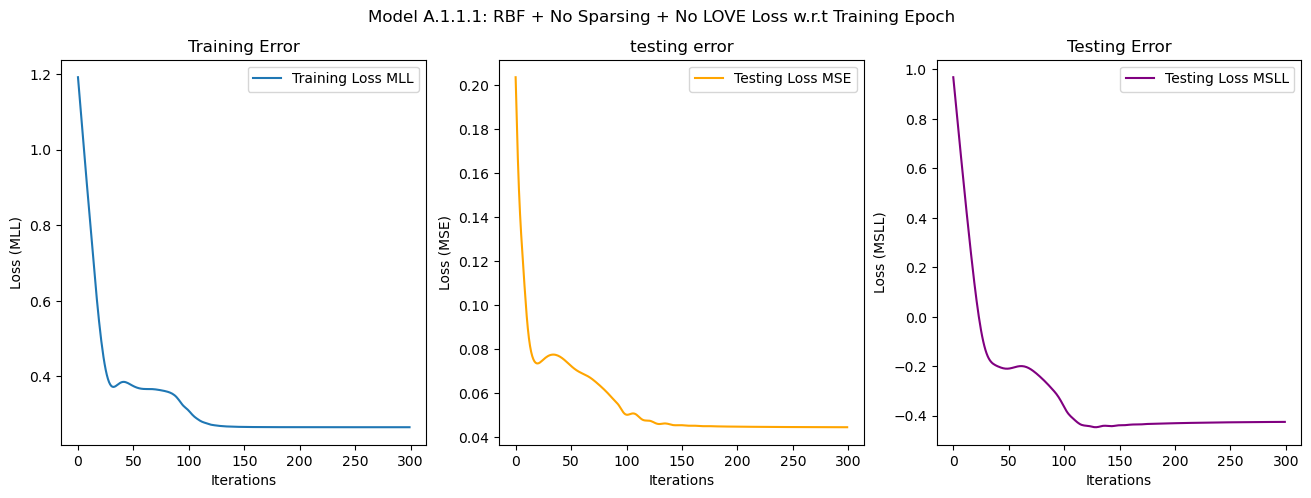

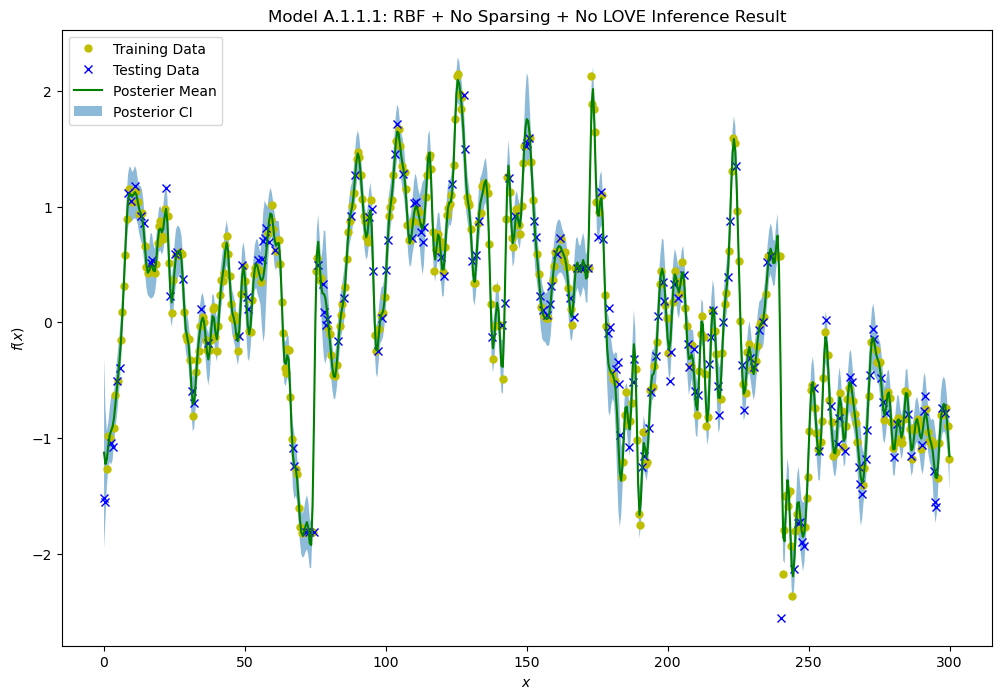

In [17]:
current_experiment_index = [0, 0, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

# inference_time = inference_time(model, likelihood, current_experiment_index)
# print(inference_time)

## Model 1.1.2: RBF + LOVE

tesing MSE after 300 epochs: 0.04452612858414301
tesing MSLL after 300 epochs: -0.42518372813527494
training duration for 300 epochs: 9.152263164520264


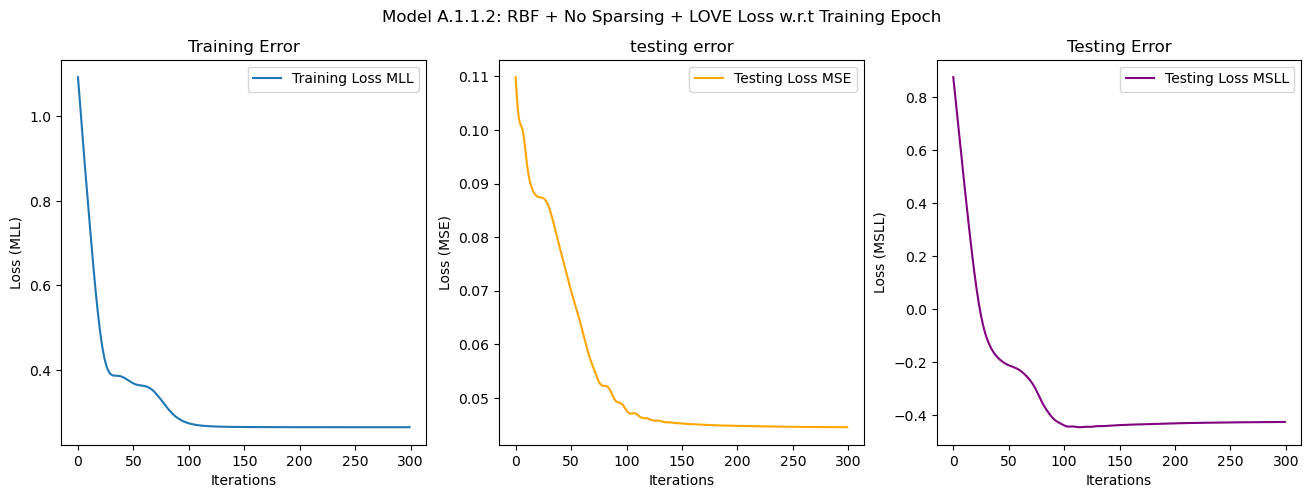

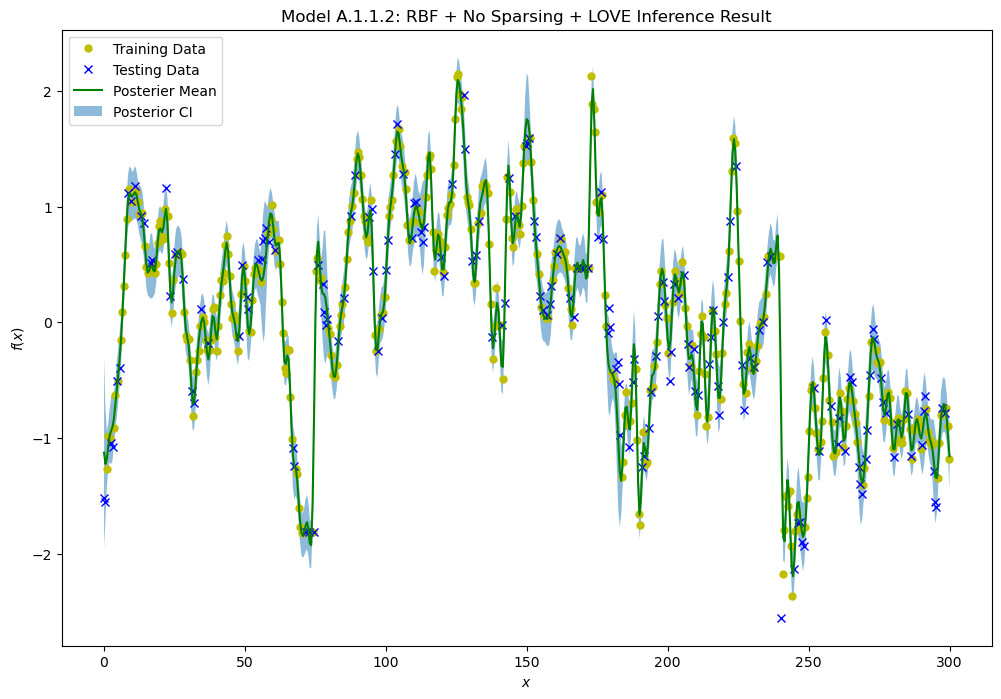

In [18]:
current_experiment_index = [0, 0, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

# inference_time = inference_time(model, likelihood, current_experiment_index)
# print(inference_time)

## Model 1.2.1: RBF + SKI

tesing MSE after 300 epochs: 0.08980383888100017
tesing MSLL after 300 epochs: 0.3189129900584561
training duration for 300 epochs: 44.91496801376343


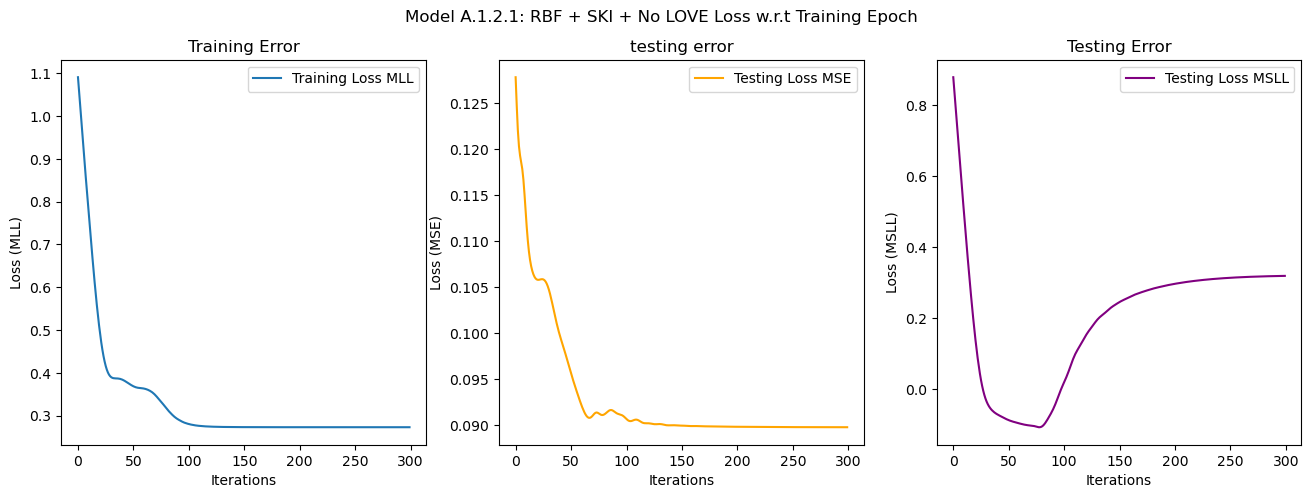

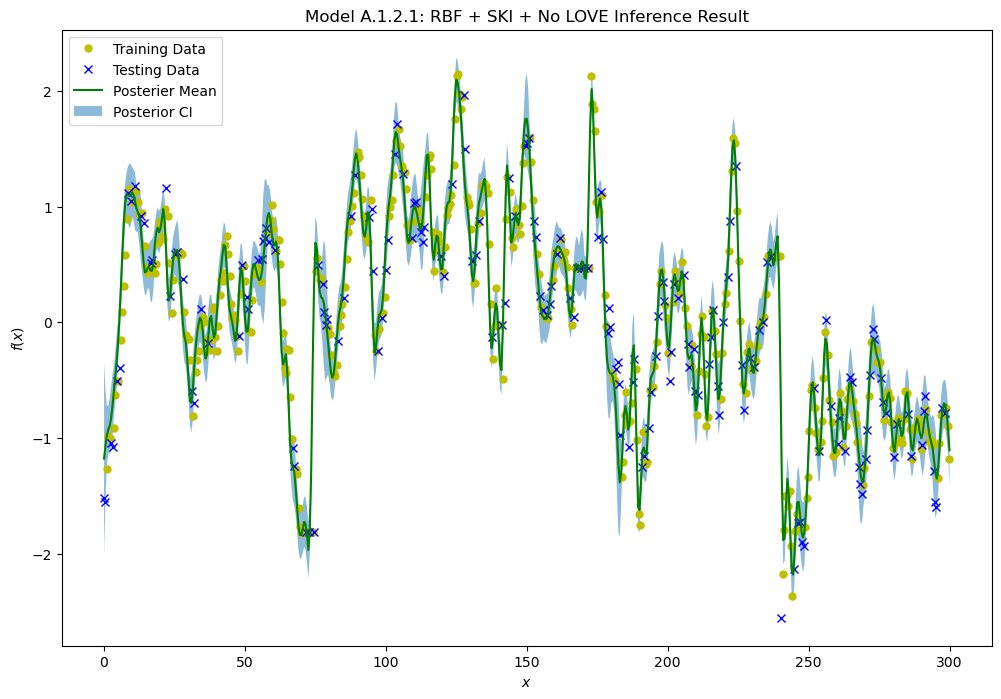

In [19]:
current_experiment_index = [0, 1, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Model 1.2.2: RBF + SKI + LOVE

tesing MSE after 300 epochs: 0.08980395492364233
tesing MSLL after 300 epochs: 0.3189153879365326
training duration for 300 epochs: 45.431769132614136


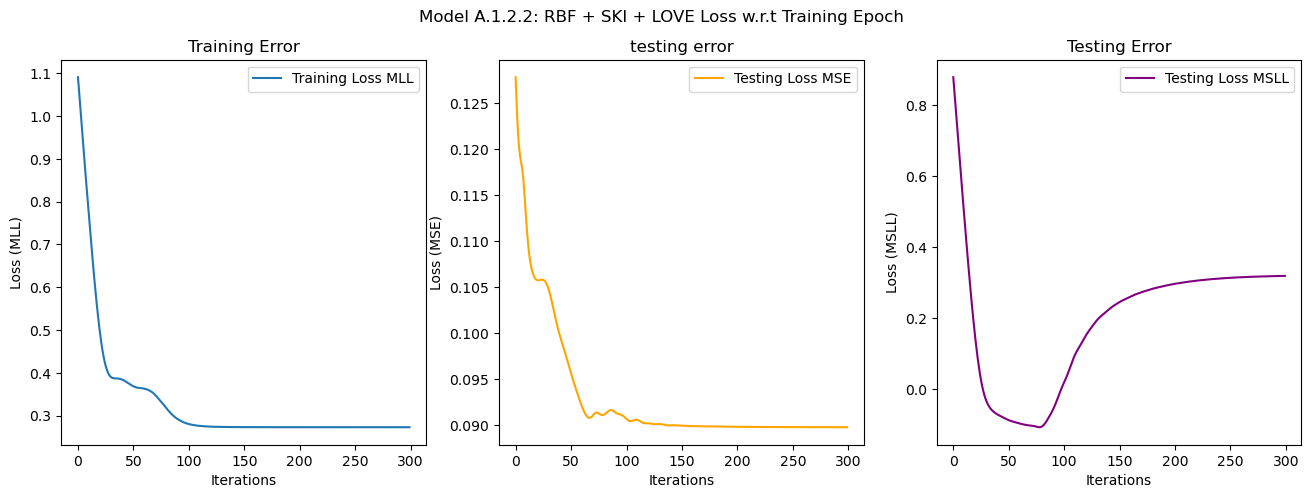

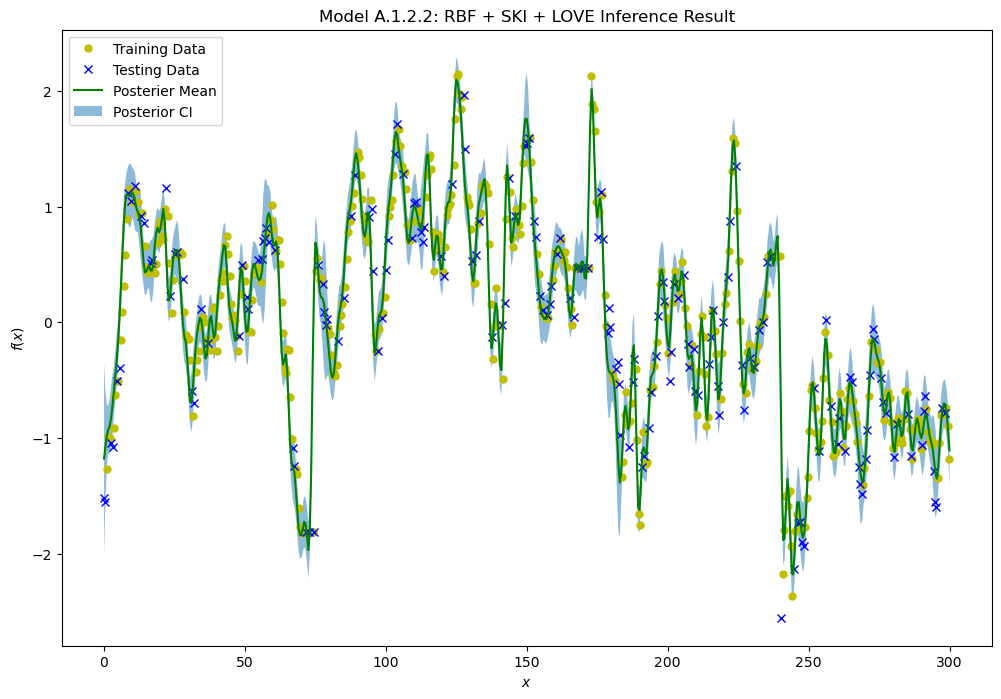

In [20]:
current_experiment_index = [0, 1, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Model 1.3.1: RBF + SGPR

tesing MSE after 300 epochs: 0.08310849595763564
tesing MSLL after 300 epochs: -0.1237152085405702
training duration for 300 epochs: 11.971646308898926


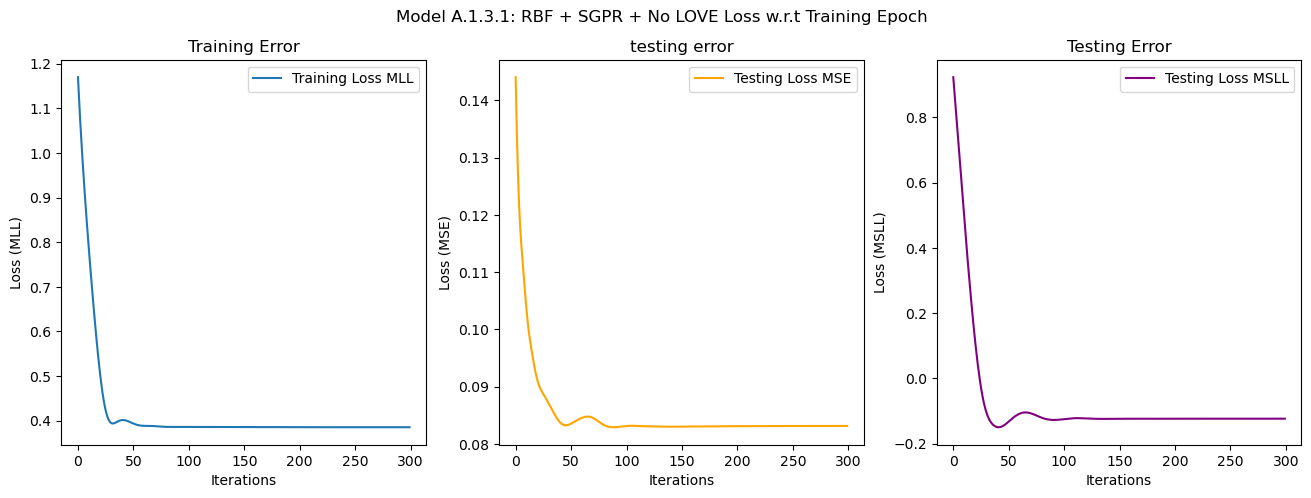

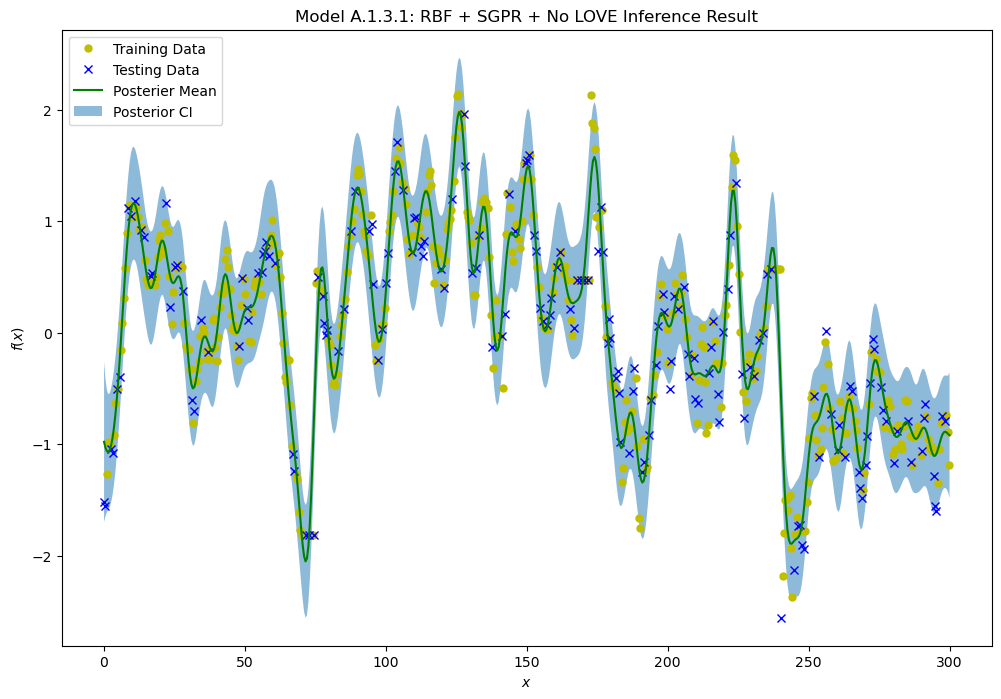

In [21]:
current_experiment_index = [0, 2, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Model 1.3.2: RBF + SGPR + LOVE

tesing MSE after 300 epochs: 0.0829277564027638
tesing MSLL after 300 epochs: -0.12419019869314232
training duration for 300 epochs: 12.24348497390747


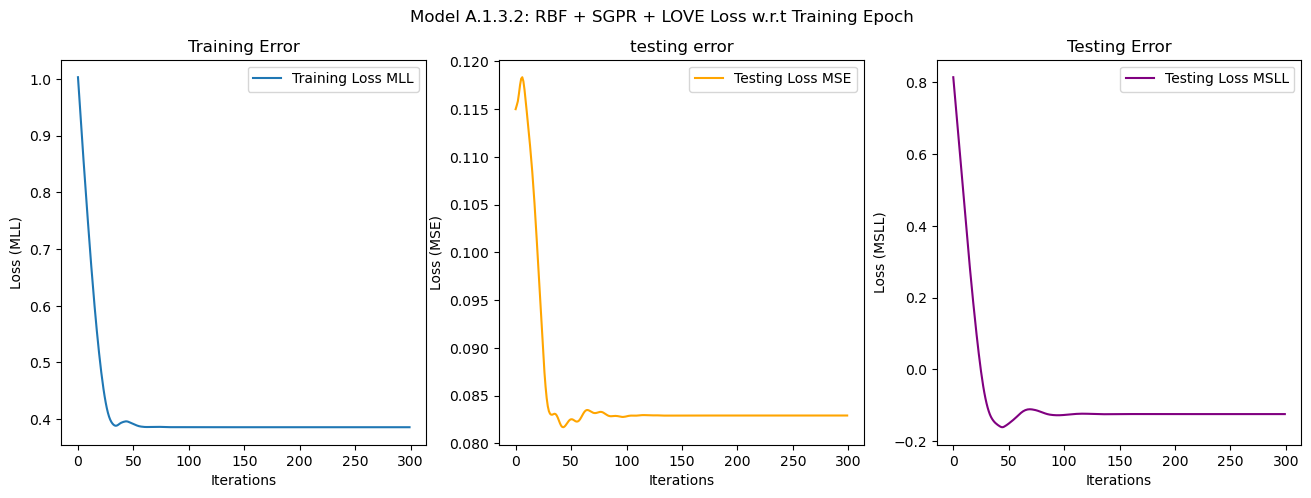

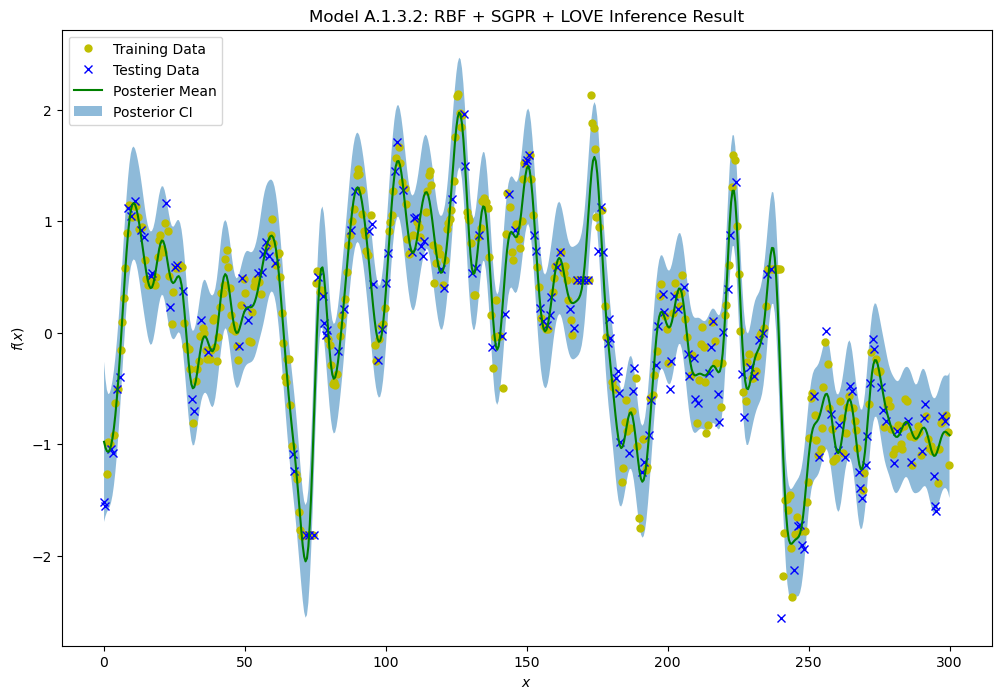

In [22]:
current_experiment_index = [0, 2, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Model 2.1.1: Periodic

tesing MSE after 300 epochs: 0.8008747330899554
tesing MSLL after 300 epochs: 1.0508220669702446
training duration for 300 epochs: 15.40085768699646


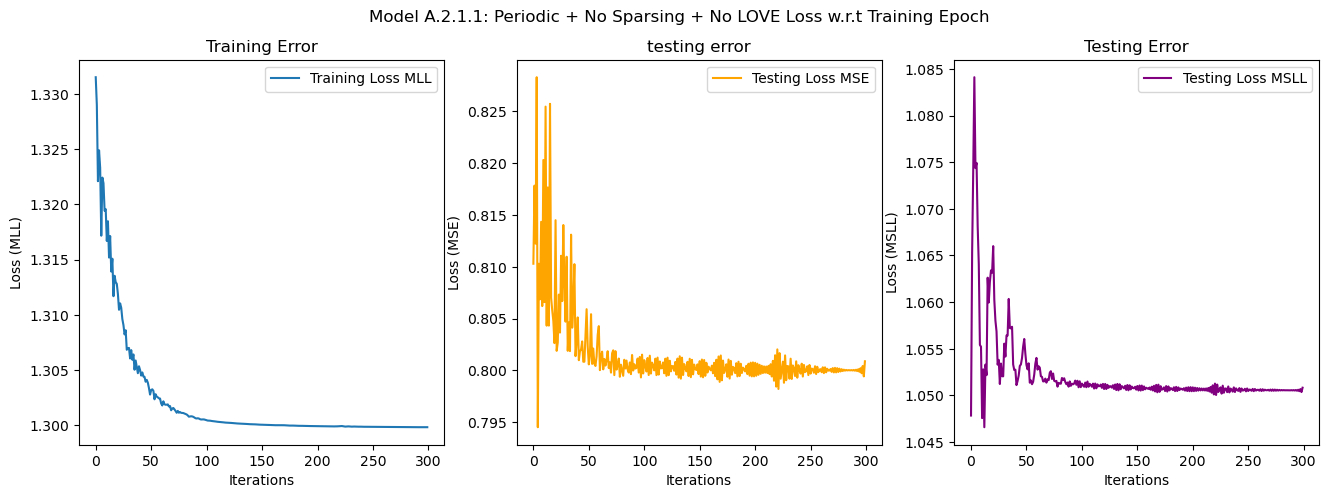

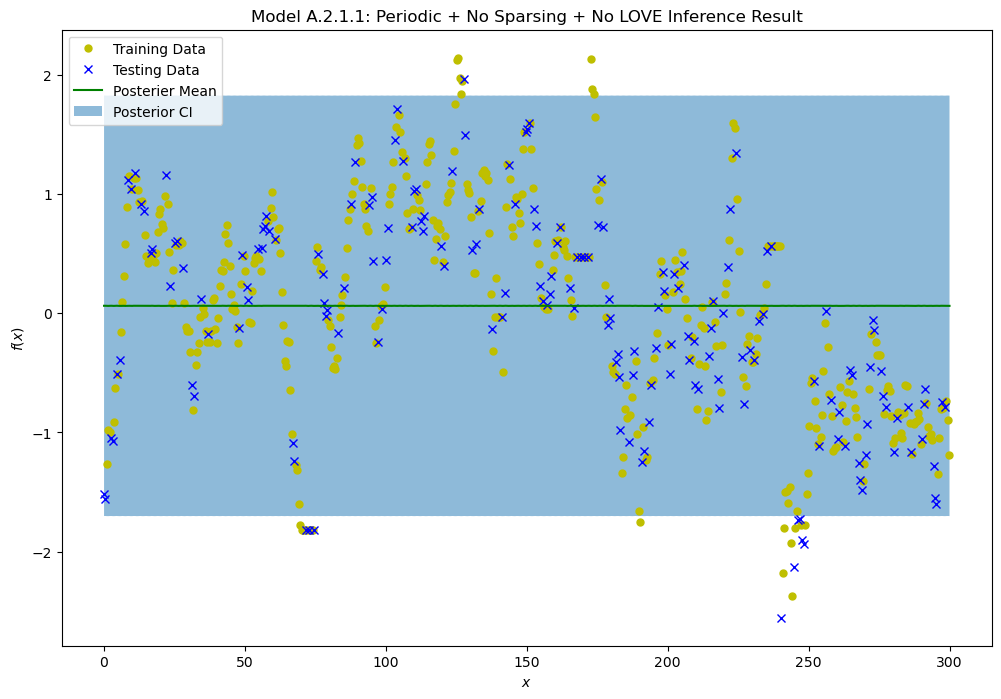

In [23]:
current_experiment_index = [1, 0, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Model 2.1.2: Periodic + LOVE

tesing MSE after 300 epochs: 0.8008451157686978
tesing MSLL after 300 epochs: 1.0507945625995523
training duration for 300 epochs: 17.191919088363647


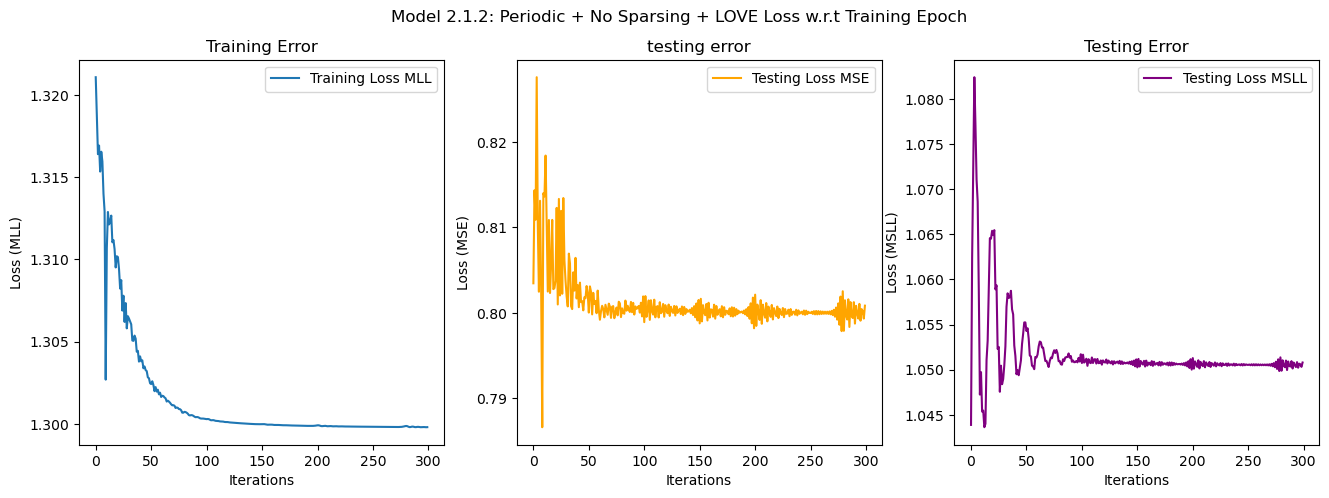

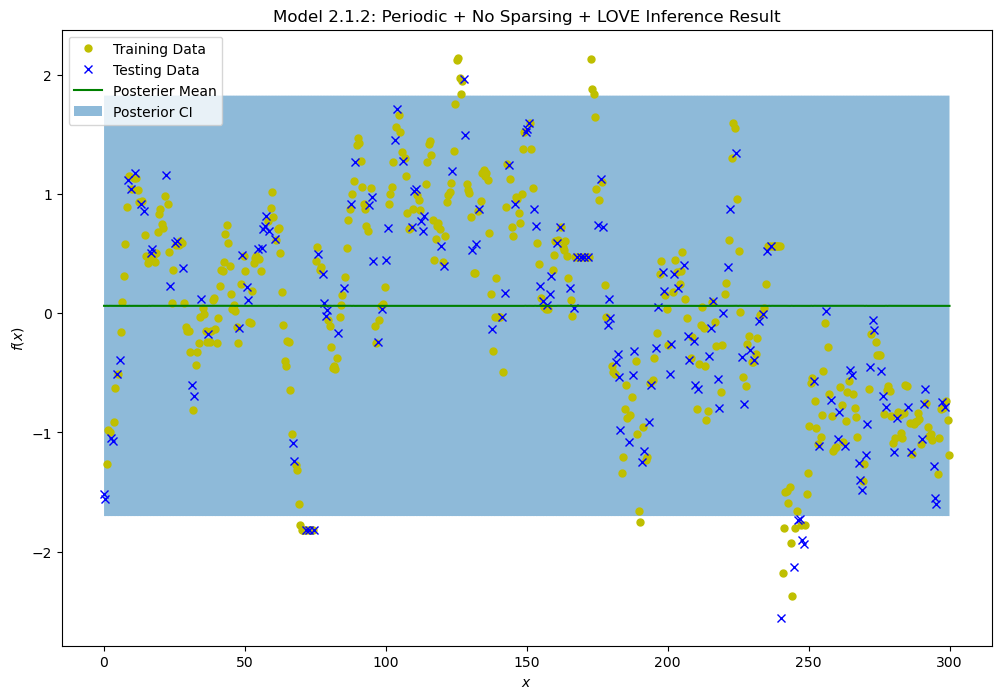

In [24]:
current_experiment_index = [1, 0, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Model 2.2.1: Periodic + SKI

/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


tesing MSE after 300 epochs: 0.7995266557388675
tesing MSLL after 300 epochs: 1.0503534525221894
training duration for 300 epochs: 42.127461194992065


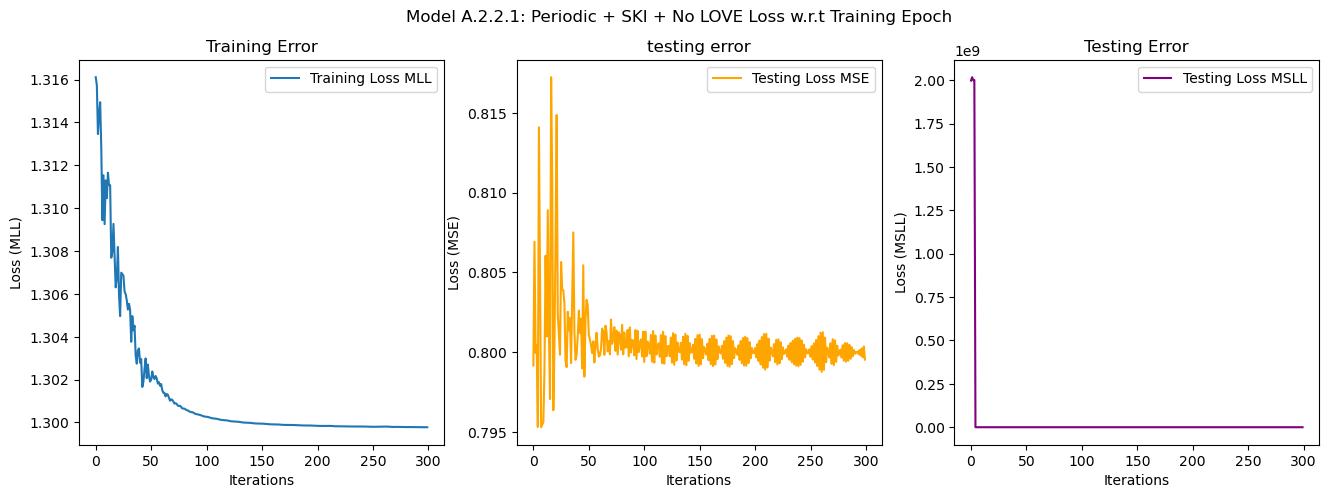

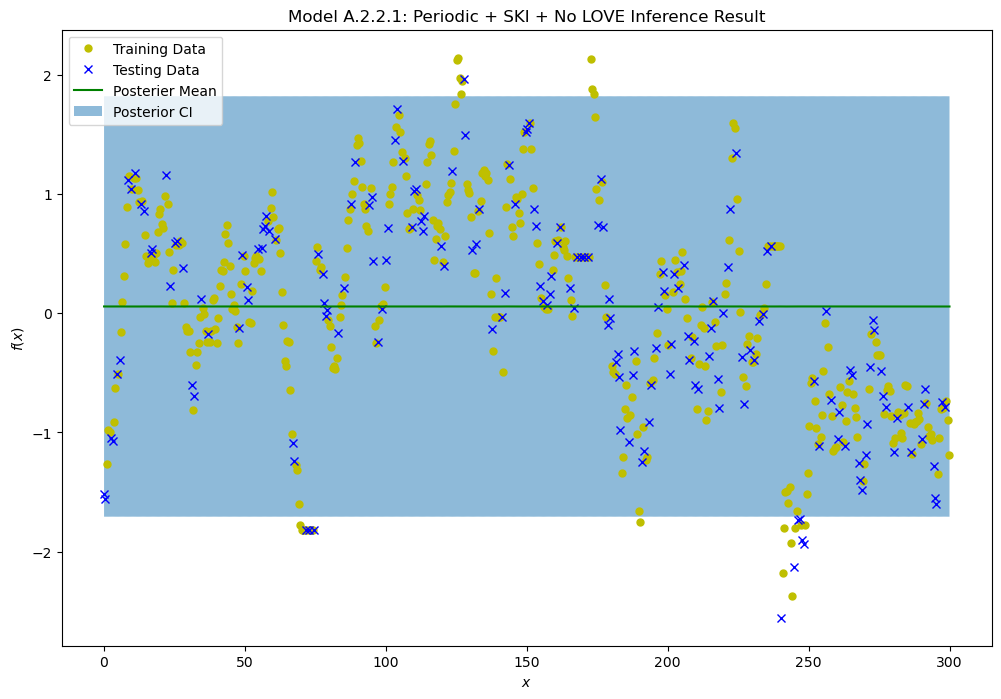

In [25]:
current_experiment_index = [1, 1, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Model 2.2.2: Periodic + SKI + LOVE

tesing MSE after 300 epochs: 0.7970076598294875
tesing MSLL after 300 epochs: 1.0495743309767573
training duration for 300 epochs: 44.98481106758118


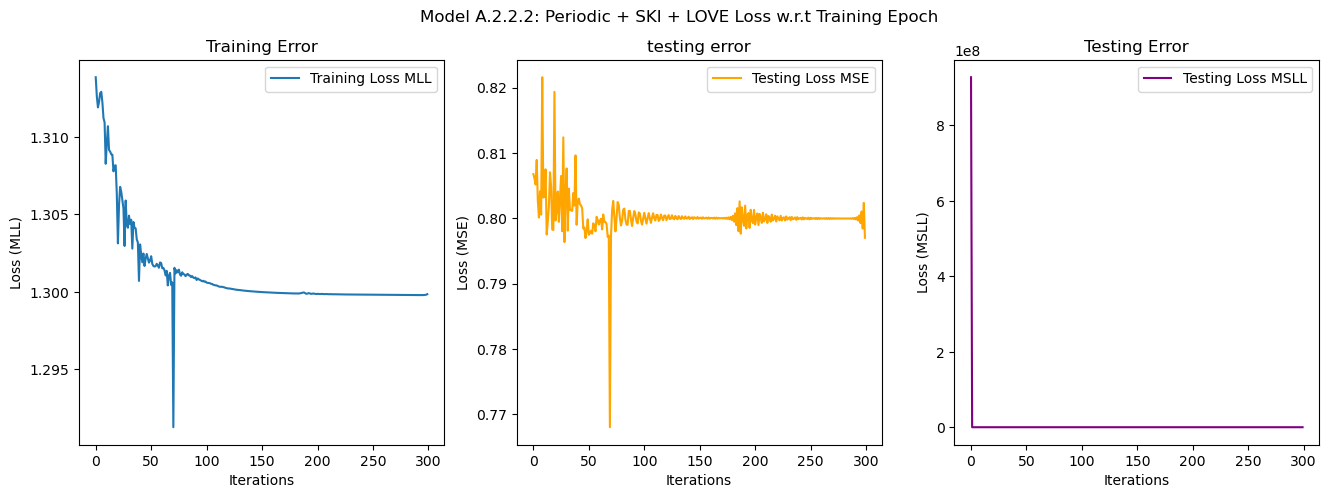

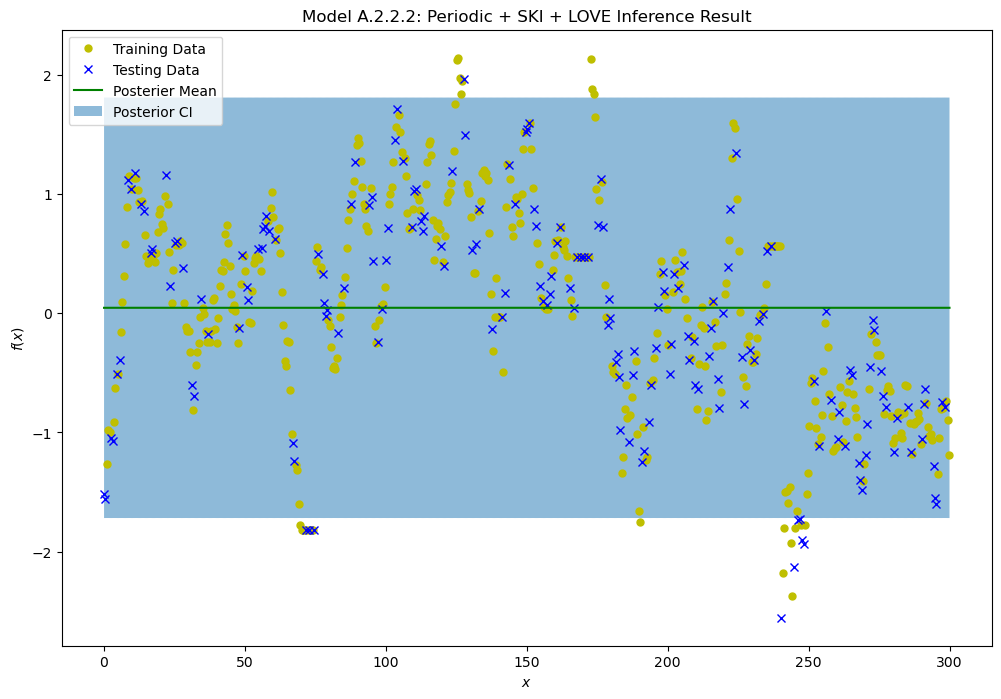

In [26]:
current_experiment_index = [1, 1, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Model 2.3.1: Periodic + SGPR

/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


tesing MSE after 300 epochs: 0.7994049322718614
tesing MSLL after 300 epochs: 1.0503125540872018
training duration for 300 epochs: 14.884485244750977


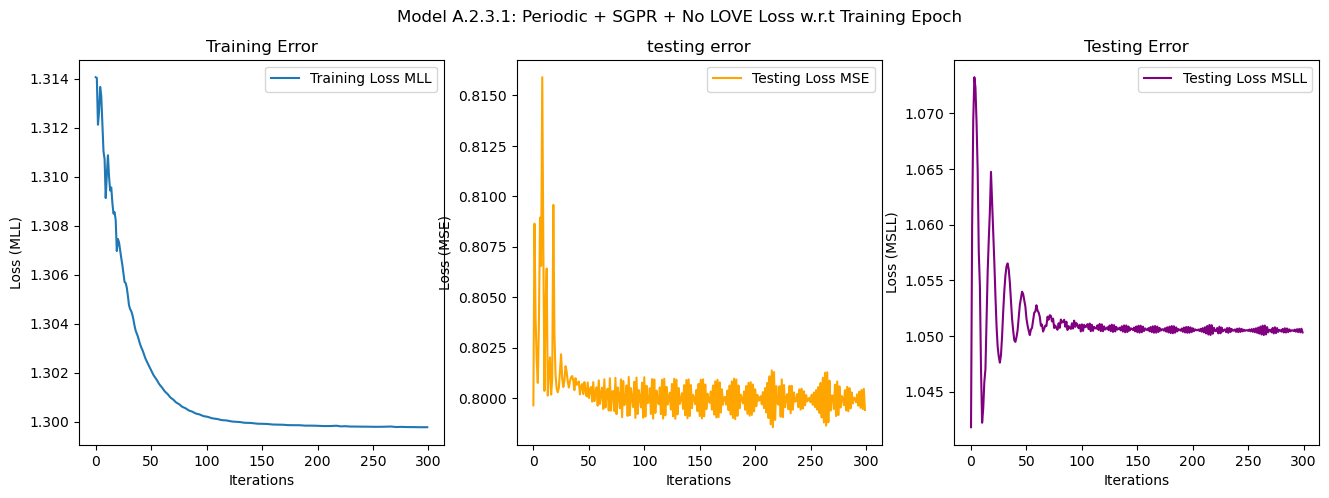

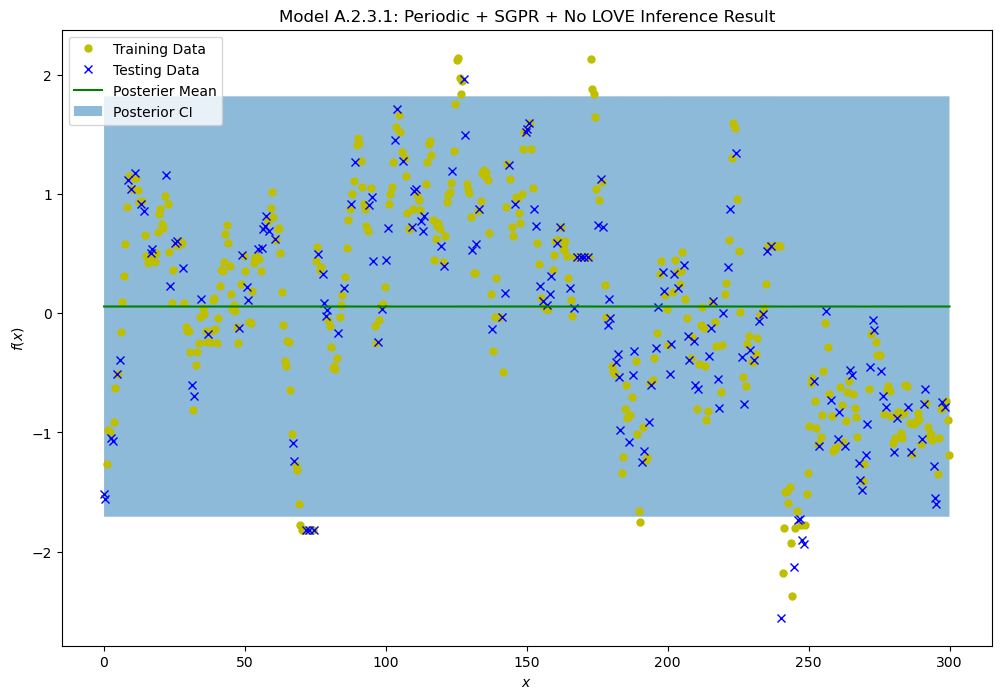

In [27]:
current_experiment_index = [1, 2, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Model 2.3.2: Periodic + SGPR + LOVE

tesing MSE after 300 epochs: 0.79958320355346
tesing MSLL after 300 epochs: 1.0503650475649604
training duration for 300 epochs: 15.010536193847656


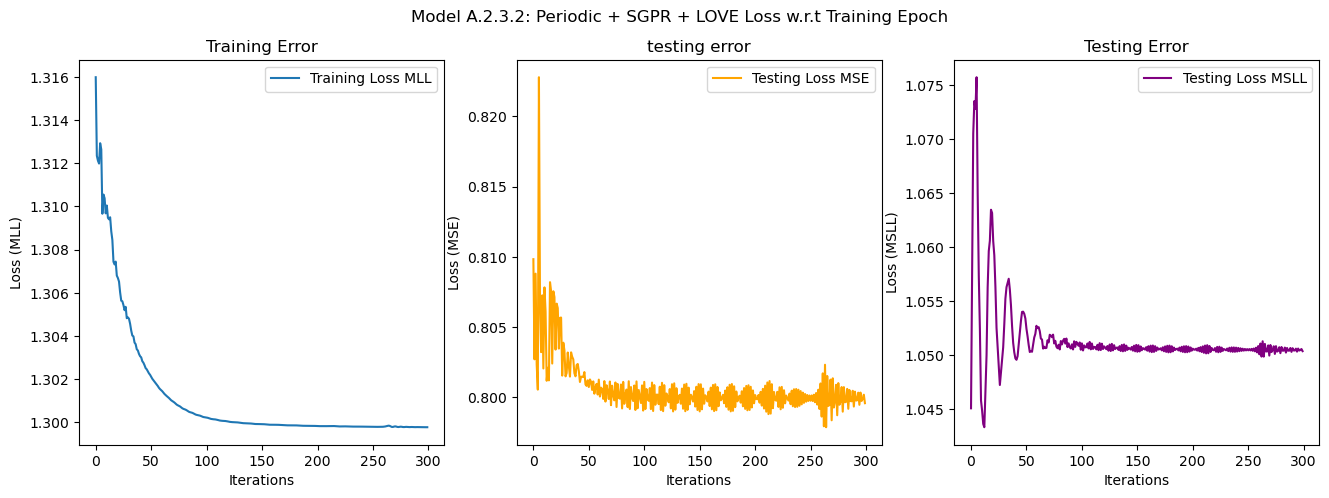

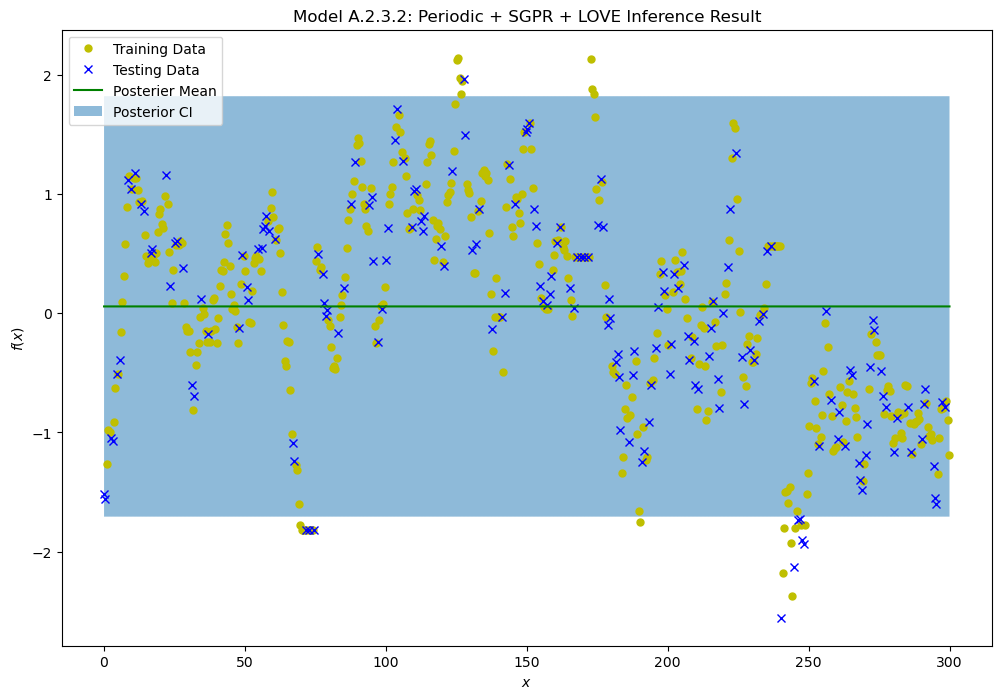

In [28]:
current_experiment_index = [1, 2, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Model 3.1.1: RBF + Periodic

tesing MSE after 300 epochs: 0.04411028100088352
tesing MSLL after 300 epochs: -0.4403191035539038
training duration for 300 epochs: 19.923831939697266


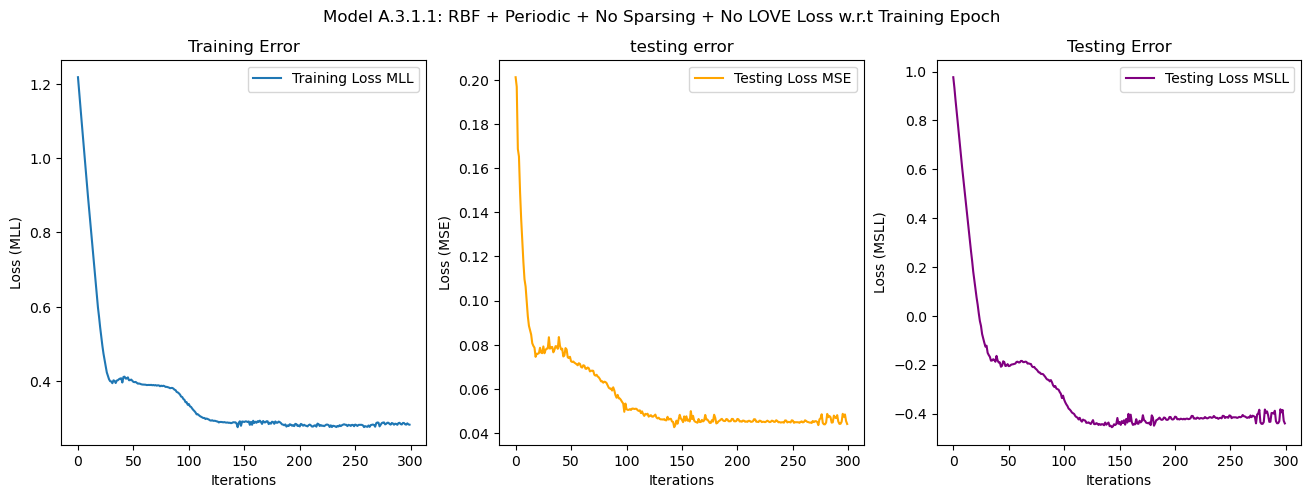

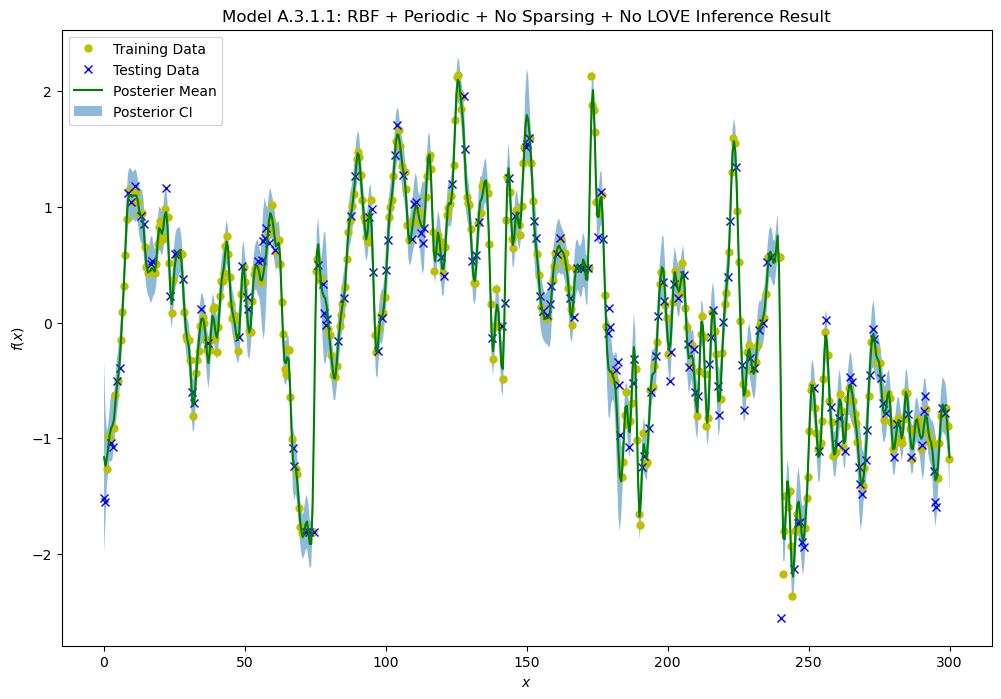

In [29]:
current_experiment_index = [2, 0, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Model 3.1.2: RBF + Periodic + LOVE

tesing MSE after 300 epochs: 0.043959880612615666
tesing MSLL after 300 epochs: -0.43124134518239793
training duration for 300 epochs: 19.673124074935913


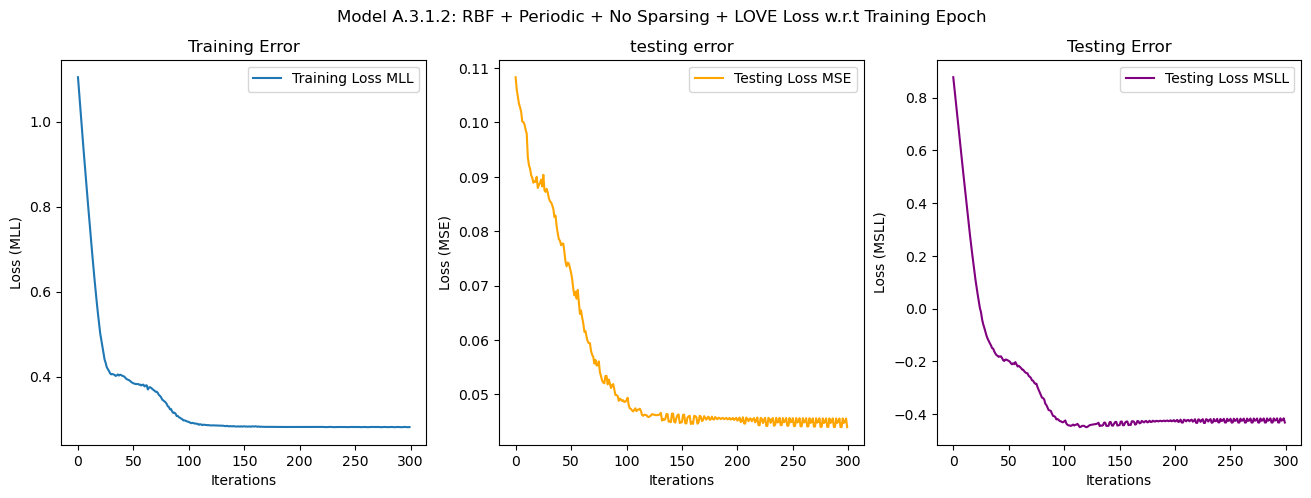

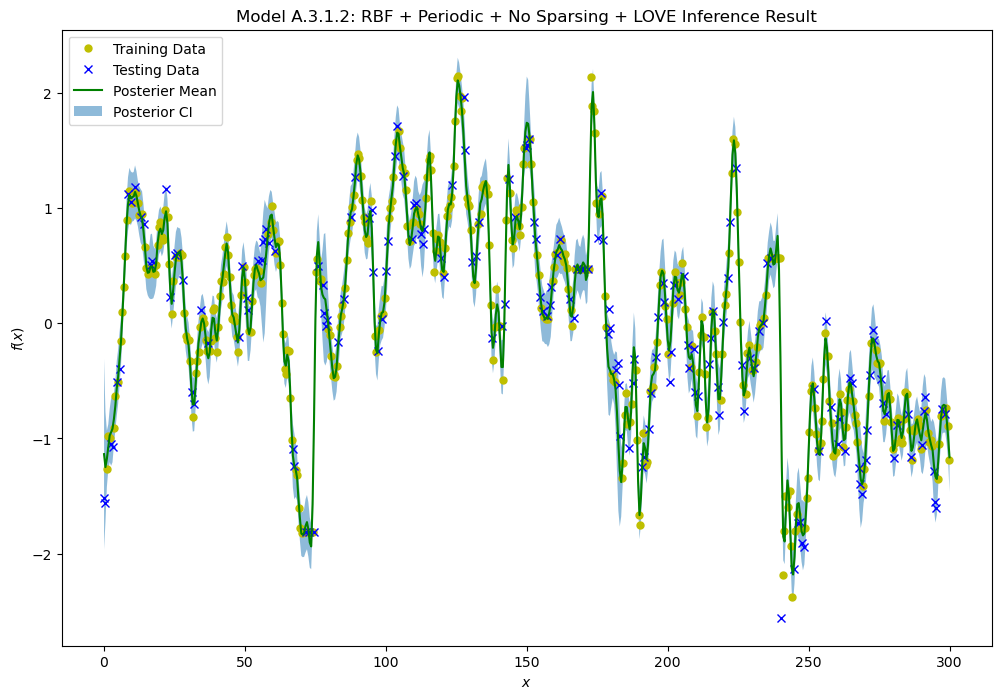

In [30]:
current_experiment_index = [2, 0, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Model 3.2.1: RBF + Periodic + SKI

tesing MSE after 300 epochs: 0.09113478216772586
tesing MSLL after 300 epochs: 0.6565803036813456
training duration for 300 epochs: 46.421595096588135


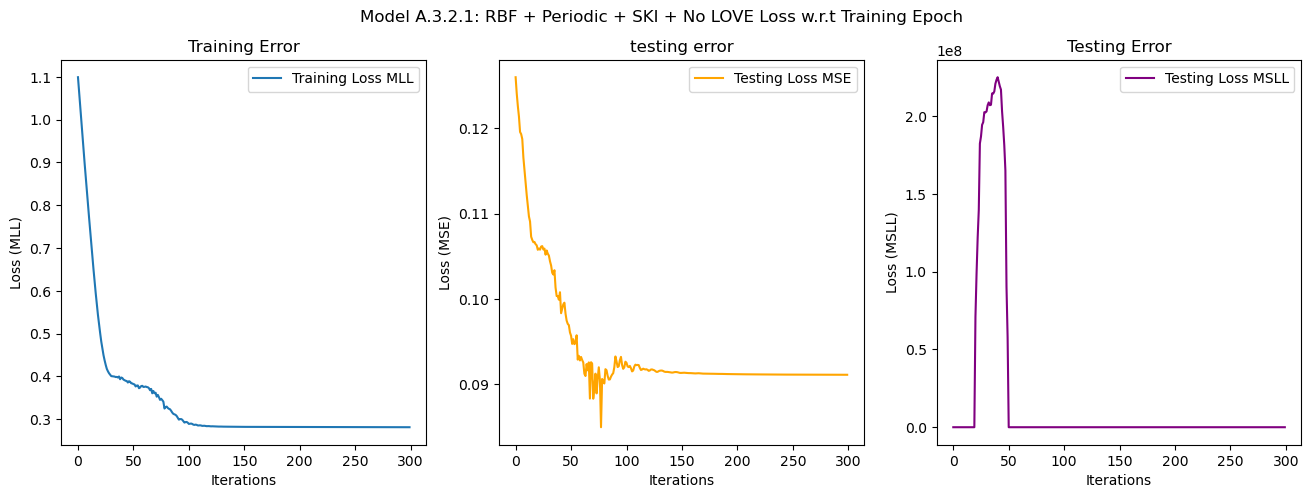

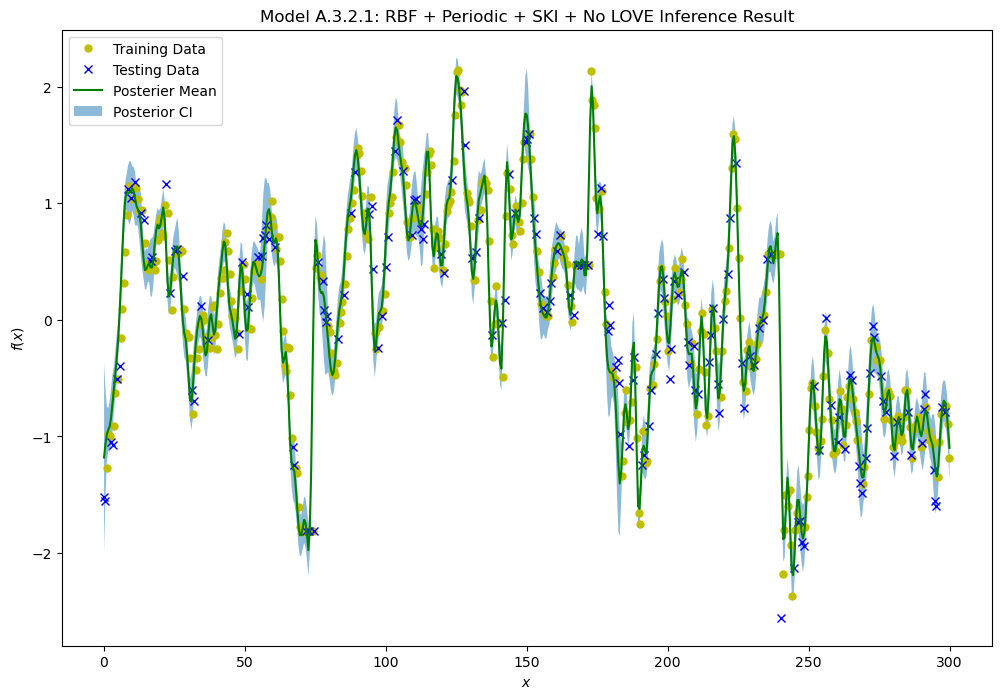

In [31]:
current_experiment_index = [2, 1, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Model 3.2.2: RBF + Periodic + SKI + LOVE

tesing MSE after 300 epochs: 0.09234573008922912
tesing MSLL after 300 epochs: 0.3924018770405275
training duration for 300 epochs: 46.557461977005005


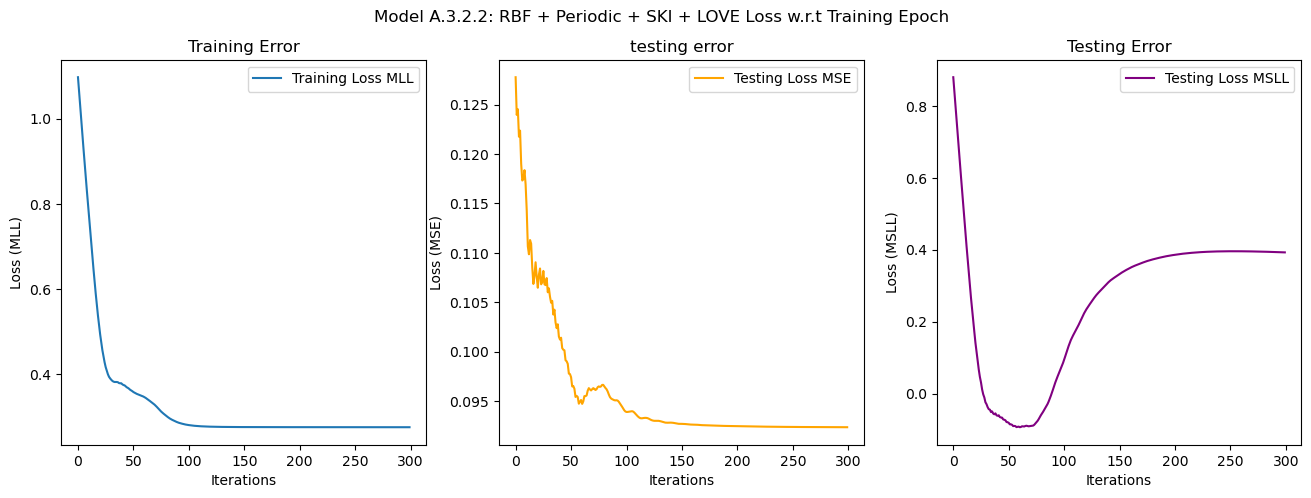

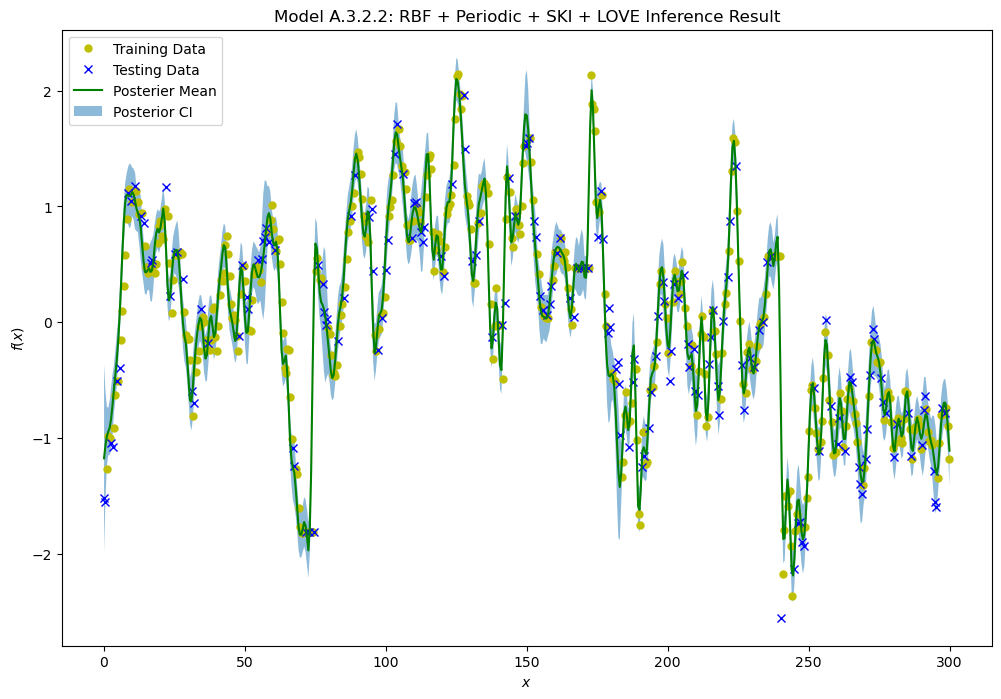

In [32]:
current_experiment_index = [2, 1, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Model 3.3.1: RBF + Periodic + SGPR

tesing MSE after 300 epochs: 0.08731418982033416
tesing MSLL after 300 epochs: -0.10871909607480248
training duration for 300 epochs: 17.616955995559692


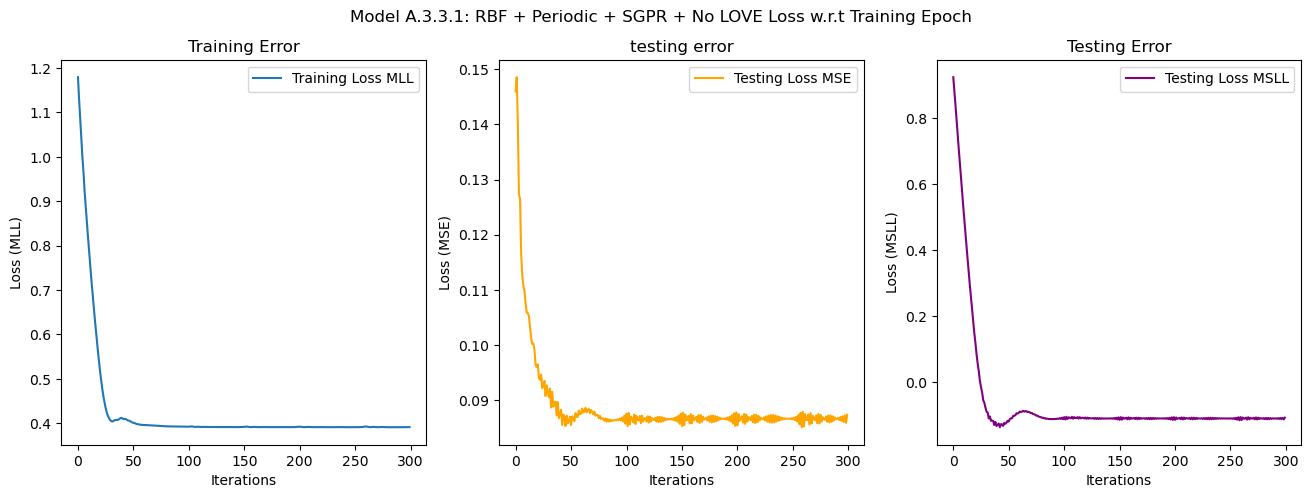

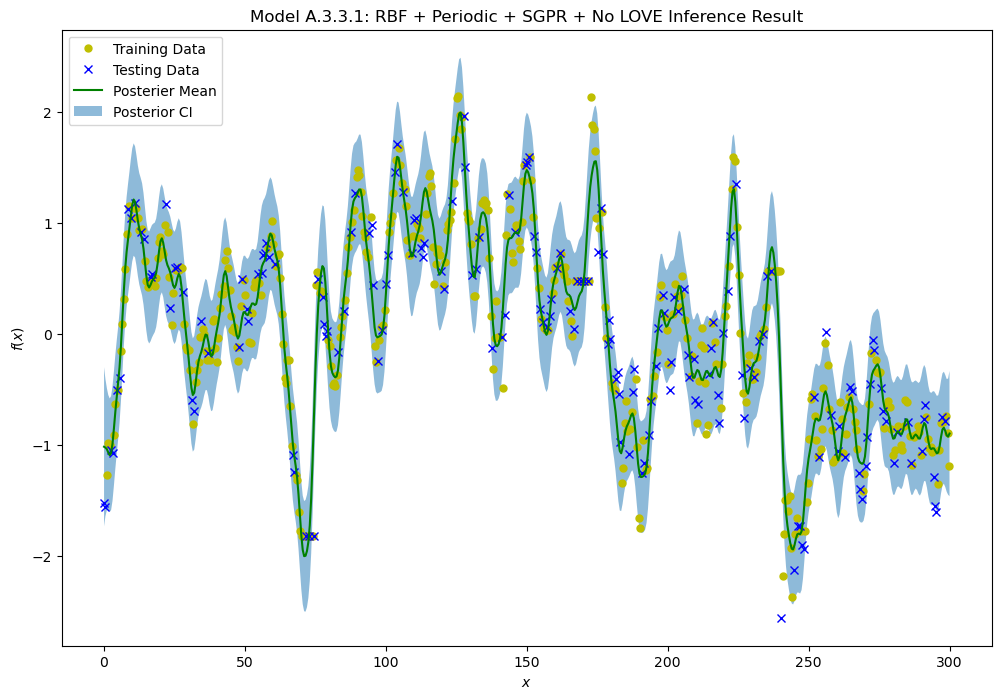

In [33]:
current_experiment_index = [2, 2, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Model 3.3.2: RBF + Periodic + SGPR + LOVE

tesing MSE after 300 epochs: 0.08192968814059905
tesing MSLL after 300 epochs: -0.12907556786106666
training duration for 300 epochs: 15.767910957336426


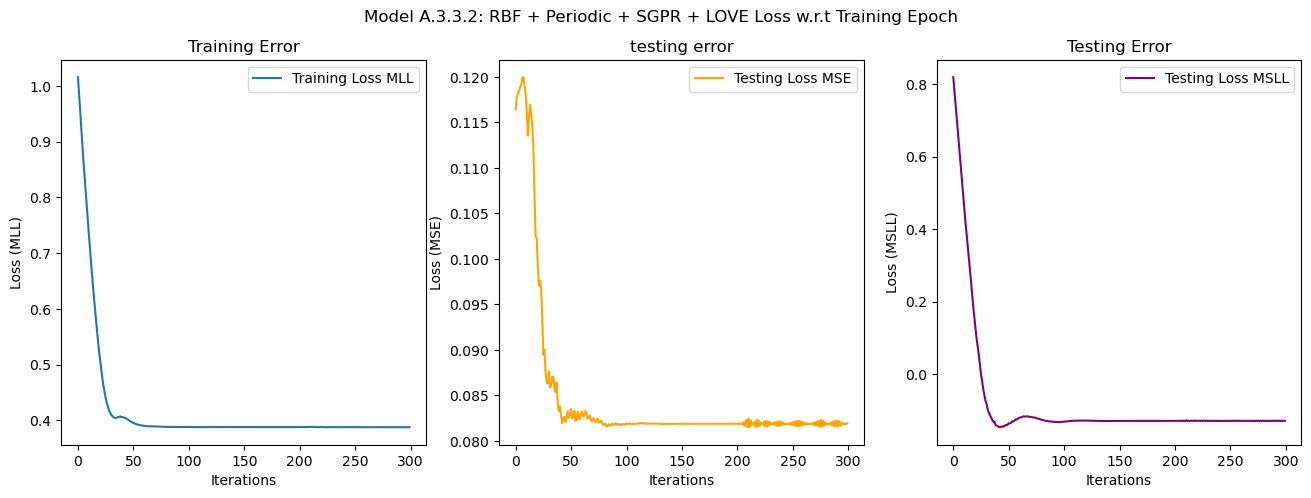

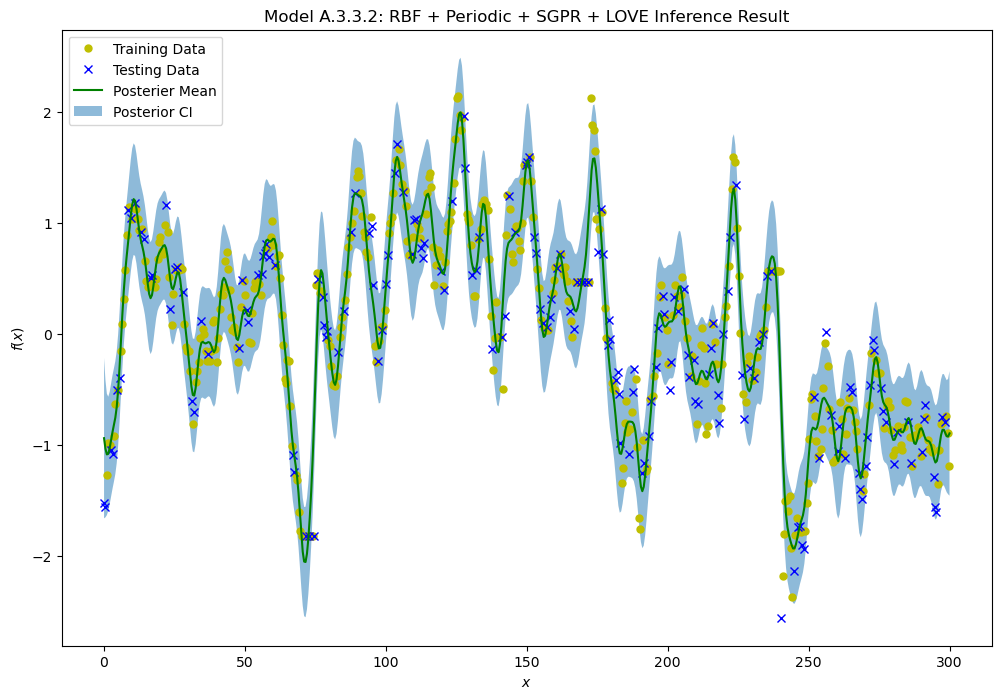

In [34]:
current_experiment_index = [2, 2, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)


#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#record loss & duration log
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
if current_experiment_index[2] == 0: #without love
    plot_predicting_result_NO_LOVE(model, likelihood, experiment_index = current_experiment_index)
else:  #with love
    plot_predicting_result_LOVE(model, likelihood, experiment_index = current_experiment_index)

## Speed Analysis

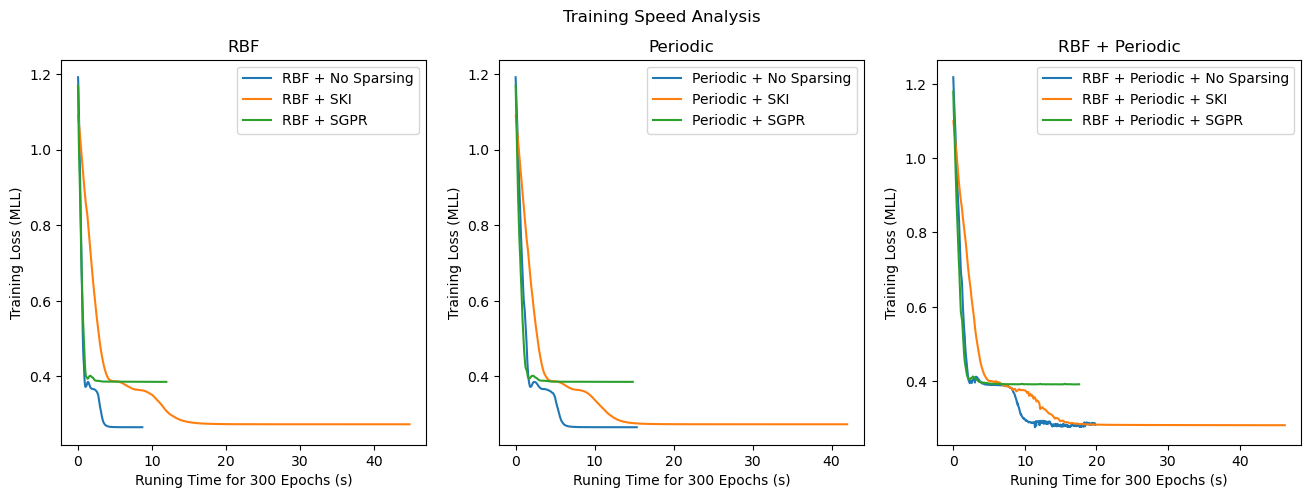

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Training Speed Analysis')

axs[0].plot(time_list_list[0][0][0], train_losses_mll_list[0][0][0], label = 'RBF + No Sparsing')
axs[0].plot(time_list_list[0][1][0], train_losses_mll_list[0][1][0], label = 'RBF + SKI')
axs[0].plot(time_list_list[0][2][0], train_losses_mll_list[0][2][0], label = 'RBF + SGPR')
axs[0].set_xlabel('Runing Time for 300 Epochs (s)')
axs[0].set_ylabel('Training Loss (MLL)')
axs[0].set_title('RBF')
axs[0].legend()

axs[1].set_xlabel('Runing Time for 300 Epochs (s)')
axs[1].set_ylabel('Training Loss (MLL)')
axs[1].plot(time_list_list[1][0][0], train_losses_mll_list[0][0][0], label = 'Periodic + No Sparsing')
axs[1].plot(time_list_list[1][1][0], train_losses_mll_list[0][1][0], label = 'Periodic + SKI')
axs[1].plot(time_list_list[1][2][0], train_losses_mll_list[0][2][0], label = 'Periodic + SGPR')
axs[1].set_title('Periodic')
axs[1].legend()

axs[2].set_xlabel('Runing Time for 300 Epochs (s)')
axs[2].set_ylabel('Training Loss (MLL)')
axs[2].plot(time_list_list[2][0][0], train_losses_mll_list[2][0][0], label = 'RBF + Periodic + No Sparsing')
axs[2].plot(time_list_list[2][1][0], train_losses_mll_list[2][1][0], label = 'RBF + Periodic + SKI')
axs[2].plot(time_list_list[2][2][0], train_losses_mll_list[2][2][0], label = 'RBF + Periodic + SGPR')
axs[2].set_title('RBF + Periodic')
axs[2].legend()

save_to = 'Experiment_A_Figure/Training Speed Analysis.png'
plt.savefig(save_to)